<a href="https://colab.research.google.com/github/AARYA2k04/Predicting-Disease-Progression-for-ALS-uding-FFNN-and-LSTM/blob/main/Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***merging*** two datasets

In [ ]:
import pandas as pd

# Load the datasets
alsfrs_path = 'alsfrs.csv'
riluzole_path = 'Riluzole.csv'

# Read the CSV files
alsfrs_df = pd.read_csv('/content/alsfrs.csv')
riluzole_df = pd.read_csv('/content/Riluzole.csv')

# Check the initial structure of both datasets
alsfrs_df.head(), riluzole_df.head()



<ipython-input-1-16d6efd22dcd>:8: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  alsfrs_df = pd.read_csv('/content/alsfrs.csv')


(   subject_id  Q1_Speech  Q2_Salivation  Q3_Swallowing  Q4_Handwriting  \
 0         329        4.0            3.0            4.0             3.0   
 1         329        4.0            3.0            4.0             3.0   
 2         329        3.0            3.0            4.0             3.0   
 3         329        4.0            2.0            4.0             3.0   
 4         329        4.0            3.0            4.0             3.0   
 
    Q5a_Cutting_without_Gastrostomy  Q5b_Cutting_with_Gastrostomy  \
 0                              2.0                           NaN   
 1                              3.0                           NaN   
 2                              4.0                           NaN   
 3                              1.0                           NaN   
 4                              2.0                           NaN   
 
    Q6_Dressing_and_Hygiene  Q7_Turning_in_Bed  Q8_Walking  Q9_Climbing_Stairs  \
 0                      3.0                2.0    

In [ ]:
# Filter ALSFRS scores for the 3rd and 12th months
# Assuming ALSFRS_Delta column represents time difference, and we can filter using this.

# ALSFRS score at 3rd month (closest to Delta ~ 90 days)
alsfrs_3m = merged_df.loc[(merged_df['ALSFRS_Delta'] >= 60) & (merged_df['ALSFRS_Delta'] <= 120)]

# ALSFRS score at 12th month (closest to Delta ~ 365 days)
alsfrs_12m = merged_df.loc[(merged_df['ALSFRS_Delta'] >= 330) & (merged_df['ALSFRS_Delta'] <= 400)]

# Ensure that we only keep subjects present in both timeframes (3rd and 12th month)
common_subjects = set(alsfrs_3m['subject_id']).intersection(set(alsfrs_12m['subject_id']))

# Filter to keep only common subjects
alsfrs_3m = alsfrs_3m[alsfrs_3m['subject_id'].isin(common_subjects)]
alsfrs_12m = alsfrs_12m[alsfrs_12m['subject_id'].isin(common_subjects)]

# Merge the two dataframes on subject_id to compute the slope
merged_timepoints = pd.merge(alsfrs_3m[['subject_id', 'ALSFRS_Total']], alsfrs_12m[['subject_id', 'ALSFRS_Total']],
                             on='subject_id', suffixes=('_3m', '_12m'))

# Calculate the slope
merged_timepoints['slope'] = (merged_timepoints['ALSFRS_Total_12m'] - merged_timepoints['ALSFRS_Total_3m']) / (12 - 3)

# Now merge this back with the Riluzole usage data
merged_timepoints = pd.merge(merged_timepoints, merged_df[['subject_id', 'Subject_used_Riluzole']], on='subject_id')

# Check the result
merged_timepoints.head()


NameError: name 'merged_df' is not defined

# *cleaned data*

In [ ]:
# Drop rows with missing ALSFRS_Total values in either the 3rd or 12th month
valid_slope_data = merged_timepoints.dropna(subset=['ALSFRS_Total_3m', 'ALSFRS_Total_12m'])

# Check the cleaned data
valid_slope_data.head()


,subject_id,ALSFRS_Total_3m,ALSFRS_Total_12m,slope,Subject_used_Riluzole
90,533,29.0,22.0,-0.777778,NaN
91,533,29.0,22.0,-0.777778,NaN
92,533,29.0,22.0,-0.777778,NaN
93,533,29.0,22.0,-0.777778,NaN
94,533,29.0,22.0,-0.777778,NaN


### size of dataset

In [ ]:
# Get the number of rows in valid_slope_data
num_rows = valid_slope_data.shape[0]

# Display the number of rows
print(f"Number of rows: {num_rows}")


Number of rows: 51857


# final dataset

In [ ]:
# Save the valid_slope_data dataframe to an Excel file
valid_slope_data.to_excel("valid_slope_data.xlsx", index=False)

# Provide the path for download
"valid_slope_data.xlsx"


'valid_slope_data.xlsx'

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the dataset from the provided Excel file
data = pd.read_excel('valid_slope_data.xlsx')

# Filter the data for subjects who used Riluzole
filtered_data = data[data['Subject_used_Riluzole'] == 'Yes']

# Extract features and target
X = filtered_data[['ALSFRS_Total_3m', 'ALSFRS_Total_12m']].values
y = filtered_data['slope'].values


In [ ]:
X_static = filtered_data[['ALSFRS_Total_3m']].values  # Static input
X_sequence = filtered_data[['ALSFRS_Total_3m', 'ALSFRS_Total_12m']].values  # Time-series input
y = filtered_data['slope'].values


# ffnn-lstm model

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the dataset
data = pd.read_excel('valid_slope_data.xlsx')

# Filter for subjects who used Riluzole
filtered_data = data[data['Subject_used_Riluzole'] == 'Yes']

# Prepare the features and target
X_static = filtered_data[['ALSFRS_Total_3m']].values  # Static input
X_sequence = filtered_data[['ALSFRS_Total_3m', 'ALSFRS_Total_12m']].values  # Time-series input
y = filtered_data['slope'].values

# Reshape X_sequence for LSTM input (samples, timesteps, features)
X_sequence = X_sequence.reshape((X_sequence.shape[0], 2, 1))  # 2 timesteps with 1 feature

# Split the data into training and testing sets
X_static_train, X_static_test, X_sequence_train, X_sequence_test, y_train, y_test = train_test_split(
    X_static, X_sequence, y, test_size=0.2, random_state=42)

# Define the LSTM model for time-series data
sequence_input = Input(shape=(X_sequence_train.shape[1], X_sequence_train.shape[2]))  # LSTM input shape
lstm_out = LSTM(64, return_sequences=False)(sequence_input)  # LSTM layer

# Define the FFNN model for static features
static_input = Input(shape=(X_static_train.shape[1],))  # Static input shape
dense_out = Dense(32, activation='relu')(static_input)  # Dense layer for static input

# Merge LSTM and FFNN outputs
merged = concatenate([lstm_out, dense_out])  # Concatenate outputs from LSTM and Dense layers
final_output = Dense(1, activation='linear')(merged)  # Final output layer for regression

# Compile the model
model = Model(inputs=[sequence_input, static_input], outputs=final_output)
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history = model.fit([X_sequence_train, X_static_train], y_train, epochs=50, batch_size=16, validation_split=0.3, verbose=1)

# Predict on the test set
y_pred = model.predict([X_sequence_test, X_static_test])

# Calculate RMSD (Root Mean Squared Deviation)
rmsd = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate Pearson Correlation Coefficient (PCC)
pcc = np.corrcoef(y_test, y_pred.flatten())[0, 1]

# Print the evaluation metrics
print(f"Root Mean Squared Deviation (RMSD): {rmsd}")
print(f"Pearson Correlation Coefficient (PCC): {pcc}")


Epoch 1/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 13.0205 - root_mean_squared_error: 3.0629 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 2/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0430 - val_loss: 6.7480e-04 - val_root_mean_squared_error: 0.0260
Epoch 3/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 4.7597e-04 - root_mean_squared_error: 0.0217 - val_loss: 1.3351e-04 - val_root_mean_squared_error: 0.0116
Epoch 4/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.7990e-04 - root_mean_squared_error: 0.0134 - val_loss: 5.1361e-04 - val_root_mean_squared_error: 0.0227
Epoch 5/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 1.3062e-04 - root_mean_squared_error: 0.0114 - val_loss: 4.2499e-05 - val_root_mean_squared_error: 0.0065
Epoch 6/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.4414e-04 - root_mean_squared_error: 0.0120 - val_loss: 4.5755e-05 - val_root_mean_squared_error: 0.0068
Epo

In [ ]:
model.save('als_model.h5')


# *effect of riluzole vs non-riluzole used patients*

In [ ]:
import pandas as pd

# Load datasets
alsfrs_df = pd.read_csv('/content/alsfrs.csv')
riluzole_df = pd.read_csv('/content/Riluzole.csv')

# Merge datasets on subject_id
merged_df = pd.merge(alsfrs_df, riluzole_df, on='subject_id')

# Filter for 3rd and 12th month
alsfrs_3m = merged_df.loc[(merged_df['ALSFRS_Delta'] >= 60) & (merged_df['ALSFRS_Delta'] <= 120)]
alsfrs_12m = merged_df.loc[(merged_df['ALSFRS_Delta'] >= 330) & (merged_df['ALSFRS_Delta'] <= 400)]

# Keep common subjects
common_subjects = set(alsfrs_3m['subject_id']).intersection(set(alsfrs_12m['subject_id']))
alsfrs_3m = alsfrs_3m[alsfrs_3m['subject_id'].isin(common_subjects)]
alsfrs_12m = alsfrs_12m[alsfrs_12m['subject_id'].isin(common_subjects)]

# Merge on subject_id and calculate slope
merged_timepoints = pd.merge(alsfrs_3m[['subject_id', 'ALSFRS_Total']], alsfrs_12m[['subject_id', 'ALSFRS_Total']],
                             on='subject_id', suffixes=('_3m', '_12m'))
merged_timepoints['slope'] = (merged_timepoints['ALSFRS_Total_12m'] - merged_timepoints['ALSFRS_Total_3m']) / 9

# Merge with Riluzole usage data
merged_timepoints = pd.merge(merged_timepoints, riluzole_df[['subject_id', 'Subject_used_Riluzole']], on='subject_id')

# Drop missing values
valid_slope_data = merged_timepoints.dropna()

# Compare slopes based on Riluzole usage
riluzole_users = valid_slope_data[valid_slope_data['Subject_used_Riluzole'] == 'Yes']
non_riluzole_users = valid_slope_data[valid_slope_data['Subject_used_Riluzole'] == 'No']

# Perform statistical tests (e.g., t-test) and visualization (e.g., boxplot)


<ipython-input-15-9523a007042b>:4: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  alsfrs_df = pd.read_csv('/content/alsfrs.csv')


In [ ]:
from scipy import stats

# Perform a t-test comparing the slopes of Riluzole users vs. non-users
t_stat, p_value = stats.ttest_ind(riluzole_users['slope'], non_riluzole_users['slope'], nan_policy='omit')

print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: 4.464001348275178, P-value: 8.255672210493975e-06


**P-value:** Since the p-value is much smaller than 0.05, it indicates a statistically significant difference between the slopes of ALSFRS progression for Riluzole users versus non-users.

This means the rate of ALSFRS score decline is significantly different depending on whether patients used Riluzole, suggesting that Riluzole likely affects the progression of ALS.

**T-statistic:** A high positive T-statistic (4.46) further supports the idea that Riluzole users tend to have less steep declines (slower disease progression) than non-users.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

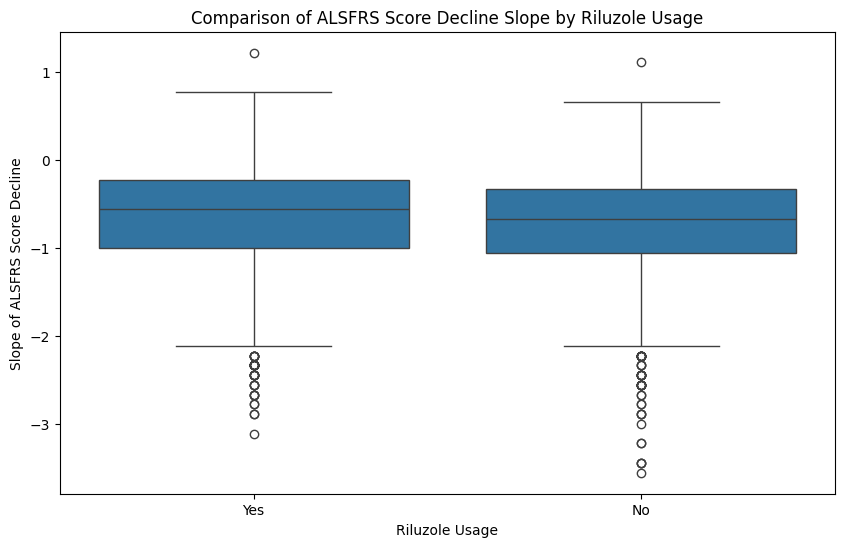

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=valid_slope_data, x='Subject_used_Riluzole', y='slope')
plt.title("Comparison of ALSFRS Score Decline Slope by Riluzole Usage")
plt.xlabel("Riluzole Usage")
plt.ylabel("Slope of ALSFRS Score Decline")
plt.show()
